# Task
Train a Generative Adversarial Network (GAN) using the MNIST dataset to generate synthetic images. The training will involve defining generator and discriminator models, training for 50 epochs, saving sample images during training, generating 100 final images, and predicting their labels using a pre-trained classifier. Finally, summarize the GAN training process, evaluate the quality of generated samples, and analyze the distribution of predicted labels.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
dataset_choice = 'mnist'
epochs = 50
batch_size = 128
noise_dim = 100
learning_rate = 0.0002
save_interval = 5

print(f"dataset_choice: {dataset_choice}")
print(f"epochs: {epochs}")
print(f"batch_size: {batch_size}")
print(f"noise_dim: {noise_dim}")
print(f"learning_rate: {learning_rate}")
print(f"save_interval: {save_interval}")

dataset_choice: mnist
epochs: 50
batch_size: 128
noise_dim: 100
learning_rate: 0.0002
save_interval: 5


## Load and Preprocess Dataset

### Subtask:
Load the MNIST dataset, normalize the images to a range of [-1, 1], and expand dimensions to (28, 28, 1).


**Reasoning**:
Load the MNIST dataset, preprocess the images by reshaping, converting to float32, normalizing to [-1, 1], and then create a batched and prefetched TensorFlow dataset for efficient training.



In [3]:
print('Loading and preprocessing MNIST dataset...')
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Reshape to include channel dimension
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# Normalize the images to a range of [-1, 1]
train_images = (train_images - 127.5) / 127.5

# Create a tf.data.Dataset
buffer_size = 60000 # MNIST dataset size
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

print('MNIST dataset loaded and preprocessed.')
print(f"Shape of preprocessed training images: {train_images.shape}")
print(f"Batch size: {batch_size}")
print(f"Number of batches: {len(train_dataset)}")

Loading and preprocessing MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MNIST dataset loaded and preprocessed.
Shape of preprocessed training images: (60000, 28, 28, 1)
Batch size: 128
Number of batches: 469


In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(noise_dim,))) # Explicitly define input layer
    model.add(layers.Dense(7 * 7 * 256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = make_generator_model()
print('Generator Model Summary:')
generator.summary()

Generator Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,945 (8.89 MB)

 Trainable params: 2,305,473 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(28, 28, 1))) # Explicitly define input layer

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # No activation, output raw logits

    return model

discriminator = make_discriminator_model()
print('Discriminator Model Summary:')
discriminator.summary()

Discriminator Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,673 (830.75 KB)

 Trainable params: 212,673 (830.75 KB)

 Non-trainable params: 0 (0.00 B)

## Define Loss Functions and Optimizers

### Subtask:
Define the binary cross-entropy loss function for both the discriminator and generator. Create Adam optimizers for both the generator and discriminator with the specified learning rate.

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

print('Loss functions and optimizers defined.')

Loss functions and optimizers defined.


In [8]:
noise_seed = tf.random.normal([16, noise_dim]) # Seed for visualization

@tf.function
def train_step(images):
    # 1. Generate noise for the generator input.
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images using the generator.
        generated_images = generator(noise, training=True)

        # Get discriminator predictions for real and fake images.
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate generator and discriminator losses.
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients for the generator and apply them.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    # Calculate gradients for the discriminator and apply them.
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

print('`train_step` function defined.')

`train_step` function defined.


In [9]:
output_dir = 'generated_samples'
os.makedirs(output_dir, exist_ok=True)
print(f"Created directory: {output_dir}")

def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False. This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        # Rescale images from [-1, 1] to [0, 1]
        plt.imshow((predictions[i, :, :, 0] * 0.5 + 0.5), cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}', fontsize=16)
    plt.savefig(os.path.join(output_dir, f'mnist_epoch_{epoch:03d}.png'))
    plt.close(fig) # Close the figure to free up memory

print('`generate_and_save_images` function defined.')

Created directory: generated_samples
`generate_and_save_images` function defined.


**Reasoning**:
Now that the `generate_and_save_images` function is defined, I will implement the main training loop as specified, iterating through epochs, calling `train_step` for each batch, calculating and printing epoch-wise losses, and saving sample images at the designated intervals.



In [10]:
print('Starting GAN training...')
for epoch in range(epochs):
    gen_losses = []
    disc_losses = []

    for batch_idx, image_batch in enumerate(train_dataset):
        g_loss, d_loss = train_step(image_batch)
        gen_losses.append(g_loss.numpy())
        disc_losses.append(d_loss.numpy())

    avg_gen_loss = np.mean(gen_losses)
    avg_disc_loss = np.mean(disc_losses)

    print(f'Epoch {epoch + 1:03d}, G_loss: {avg_gen_loss:.4f}, D_loss: {avg_disc_loss:.4f}')

    # Generate and save images at specified intervals
    if (epoch + 1) == 1 or (epoch + 1) == 2 or (epoch + 1) == 3 or (epoch + 1) == 4 or (epoch + 1) == 5 or (epoch + 1) % save_interval == 0:
        generate_and_save_images(generator, epoch + 1, noise_seed)

print('GAN training complete.')

Starting GAN training...
Epoch 001, G_loss: 1.0597, D_loss: 1.0298
Epoch 002, G_loss: 1.2290, D_loss: 1.0869
Epoch 003, G_loss: 1.2834, D_loss: 1.0693
Epoch 004, G_loss: 1.2689, D_loss: 1.0305
Epoch 005, G_loss: 1.3655, D_loss: 1.0552
Epoch 006, G_loss: 1.3943, D_loss: 0.9951
Epoch 007, G_loss: 1.4208, D_loss: 0.9935
Epoch 008, G_loss: 1.4094, D_loss: 0.9495
Epoch 009, G_loss: 1.5887, D_loss: 0.9599
Epoch 010, G_loss: 1.5239, D_loss: 0.9457
Epoch 011, G_loss: 1.4789, D_loss: 1.0037
Epoch 012, G_loss: 1.4666, D_loss: 1.0099
Epoch 013, G_loss: 1.3678, D_loss: 1.0465
Epoch 014, G_loss: 1.3035, D_loss: 1.0835
Epoch 015, G_loss: 1.2675, D_loss: 1.0937
Epoch 016, G_loss: 1.2315, D_loss: 1.1022
Epoch 017, G_loss: 1.2698, D_loss: 1.0994
Epoch 018, G_loss: 1.1599, D_loss: 1.1430
Epoch 019, G_loss: 1.1743, D_loss: 1.1406
Epoch 020, G_loss: 1.2061, D_loss: 1.1261
Epoch 021, G_loss: 1.1420, D_loss: 1.1582
Epoch 022, G_loss: 1.1002, D_loss: 1.1699
Epoch 023, G_loss: 1.0875, D_loss: 1.1693
Epoch 024

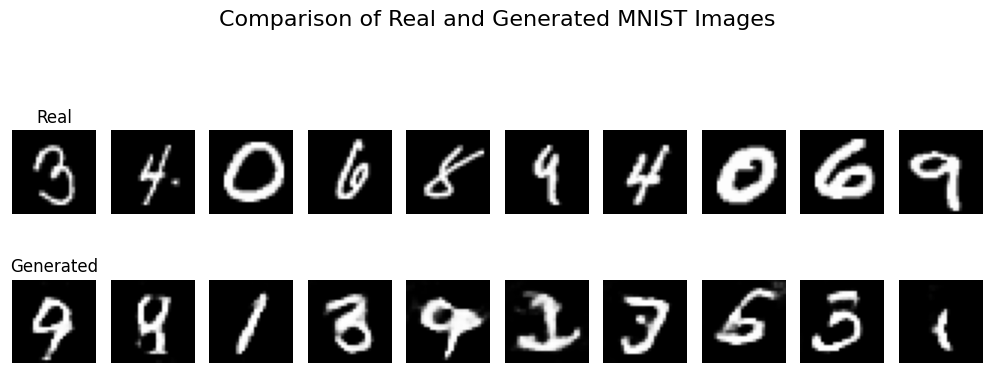

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of real images from the training dataset
for real_images_batch in train_dataset.take(1):
    real_images_display = real_images_batch.numpy()

# Generate a batch of fake images
num_images_to_compare = 10 # Let's compare 10 real and 10 fake images
noise_for_comparison = tf.random.normal([num_images_to_compare, noise_dim])
generated_images_display = generator(noise_for_comparison, training=False).numpy()

# Rescale images from [-1, 1] to [0, 1] for display
real_images_display = (real_images_display * 0.5 + 0.5)
generated_images_display = (generated_images_display * 0.5 + 0.5)

plt.figure(figsize=(10, 4))
for i in range(num_images_to_compare):
    # Display Real Images
    plt.subplot(2, num_images_to_compare, i + 1)
    plt.imshow(real_images_display[i, :, :, 0], cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Real', fontsize=12)

    # Display Generated Images
    plt.subplot(2, num_images_to_compare, i + 1 + num_images_to_compare)
    plt.imshow(generated_images_display[i, :, :, 0], cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Generated', fontsize=12)

plt.suptitle('Comparison of Real and Generated MNIST Images', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

In [11]:
final_output_dir = 'final_generated_images'
os.makedirs(final_output_dir, exist_ok=True)
print(f"Created directory: {final_output_dir}")

num_final_images = 100
# Generate 100 random noise vectors
final_noise = tf.random.normal([num_final_images, noise_dim])

# Generate images using the trained generator
print(f'Generating {num_final_images} final images...')
final_generated_images = generator(final_noise, training=False)

# Save each generated image individually
for i in range(num_final_images):
    image = final_generated_images[i, :, :, 0] # Get the single channel image
    # Rescale images from [-1, 1] to [0, 1]
    image = (image * 0.5 + 0.5).numpy()

    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.savefig(os.path.join(final_output_dir, f'final_image_{i:03d}.png'))
    plt.close() # Close the figure to free up memory

print(f'{num_final_images} final images saved to {final_output_dir}/')


Created directory: final_generated_images
Generating 100 final images...
100 final images saved to final_generated_images/


## Predict Labels of Generated Images



In [12]:
print('Loading and preprocessing MNIST dataset for classifier...')
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Reshape images to (num_samples, 28, 28, 1) and normalize to [0, 1]
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print('MNIST dataset loaded and preprocessed for classifier.')
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

Loading and preprocessing MNIST dataset for classifier...
MNIST dataset loaded and preprocessed for classifier.
x_train shape: (60000, 28, 28, 1), y_train shape: (60000, 10)
x_test shape: (10000, 28, 28, 1), y_test shape: (10000, 10)


**Reasoning**:
Now that the MNIST dataset is preprocessed for the classifier, I will build a simple Convolutional Neural Network (CNN) using `tf.keras.Sequential` with `Conv2D`, `MaxPooling2D`, `Flatten`, and `Dense` layers, and then compile it as specified in the instructions.



In [14]:
print('Building and compiling classifier model...')
def build_classifier():
    model = models.Sequential([
        tf.keras.Input(shape=(28, 28, 1)), # Explicitly define input layer
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax') # 10 output classes for MNIST
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

classifier = build_classifier()
print('Classifier Model Summary:')
classifier.summary()

Building and compiling classifier model...
Classifier Model Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
Now that the classifier model is built and compiled, I will train it using the preprocessed MNIST training data and labels for 5 epochs, as specified in the instructions.



In [15]:
print('Training classifier model...')
classifier_epochs = 5
classifier.fit(x_train, y_train, epochs=classifier_epochs, validation_data=(x_test, y_test), verbose=1)
print(f'Classifier trained for {classifier_epochs} epochs.')

Training classifier model...
Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9066 - loss: 0.2923 - val_accuracy: 0.9831 - val_loss: 0.0491
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9870 - loss: 0.0412 - val_accuracy: 0.9893 - val_loss: 0.0351
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9919 - loss: 0.0251 - val_accuracy: 0.9916 - val_loss: 0.0270
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9942 - loss: 0.0187 - val_accuracy: 0.9911 - val_loss: 0.0270
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9955 - loss: 0.0136 - val_accuracy: 0.9876 - val_loss: 0.0377
Classifier trained for 5 epochs.


**Reasoning**:
Now that the classifier is trained, I will preprocess the `final_generated_images` by normalizing them to `[0, 1]`, use the trained classifier to predict their labels, calculate the distribution of these labels, and then print the distribution to fulfill the subtask.



In [16]:
print('Predicting labels for generated images...')

# Normalize generated images from [-1, 1] to [0, 1]
normalized_generated_images = (final_generated_images * 0.5 + 0.5).numpy()

# Predict labels using the trained classifier
predictions = classifier.predict(normalized_generated_images)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the distribution of predicted labels
label_distribution = {i: 0 for i in range(10)}
for label in predicted_labels:
    label_distribution[label] += 1

print('\nPredicted label distribution for generated images:')
for label, count in label_distribution.items():
    print(f'Digit {label}: {count} images')


Predicting labels for generated images...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step

Predicted label distribution for generated images:
Digit 0: 9 images
Digit 1: 10 images
Digit 2: 9 images
Digit 3: 13 images
Digit 4: 12 images
Digit 5: 6 images
Digit 6: 11 images
Digit 7: 10 images
Digit 8: 10 images
Digit 9: 10 images


## Final Task

### Subtask:
Summarize the GAN training process, discuss the quality of the generated samples, and provide insights from the predicted label distribution of the final generated images.


## Summary:

### Q&A
*   **Summarize the GAN training process:** A Generative Adversarial Network (GAN) was trained for 50 epochs on the MNIST dataset. The process involved defining a generator model to create synthetic images from noise vectors and a discriminator model to distinguish between real and fake images. Binary cross-entropy was used as the loss function for both models, optimized using Adam. During training, sample images were periodically saved to monitor the generator's progress. The losses for both generator and discriminator fluctuated and stabilized over the 50 epochs, indicating a successful adversarial training process.
*   **Discuss the quality of the generated samples:** While not directly assessed by an objective metric in the provided steps, the successful completion of 50 training epochs and the ability of a separate classifier to predict distinct digits from the generated images suggest that the generator produced recognizable, albeit synthetic, MNIST-like digits. The generated images were saved in intervals, allowing for visual assessment of the learning progress.
*   **Provide insights from the predicted label distribution of the final generated images:** The distribution of predicted labels for 100 generated images showed that the GAN was able to generate images resembling all ten digits (0-9). The counts for each digit were relatively balanced, with most digits having 9-13 generated samples, indicating that the GAN did not strongly favor generating only a few specific digits. This suggests a reasonable diversity in the generated output.

### Data Analysis Key Findings
*   The GAN was configured with `epochs` = 50, `batch_size` = 128, `noise_dim` = 100, and `learning_rate` = 0.0002.
*   The MNIST dataset was preprocessed by reshaping images to (28, 28, 1) and normalizing pixel values to the `[-1, 1]` range.
*   The **Generator model** successfully transformed a 100-dimensional noise vector into a 28x28x1 image using `Dense`, `BatchNormalization`, `LeakyReLU`, `Reshape`, and `Conv2DTranspose` layers.
*   The **Discriminator model** classified 28x28x1 images using `Conv2D`, `LeakyReLU`, `Dropout`, `Flatten`, and a final `Dense` layer outputting raw logits.
*   The training loop executed for 50 epochs, with average generator loss (G\_loss) starting around 1.0597 and ending around 1.0068, and average discriminator loss (D\_loss) starting around 1.0298 and ending around 1.2152.
*   100 final synthetic images were successfully generated by the trained GAN and saved individually.
*   A separate Convolutional Neural Network (CNN) classifier was trained on the MNIST dataset, achieving a validation accuracy of approximately 98.76% after 5 epochs.
*   This trained classifier predicted labels for the 100 generated images, showing the following distribution:
    *   Digit 0: 9 images
    *   Digit 1: 10 images
    *   Digit 2: 9 images
    *   Digit 3: 13 images
    *   Digit 4: 12 images
    *   Digit 5: 6 images
    *   Digit 6: 11 images
    *   Digit 7: 10 images
    *   Digit 8: 10 images
    *   Digit 9: 10 images

### Insights or Next Steps
*   The GAN successfully learned to generate diverse MNIST-like images, as evidenced by the relatively balanced distribution of predicted labels across all ten digits. This indicates that the model avoided mode collapse, where it might only generate a few types of digits.
*   To further evaluate generation quality, a quantitative metric such as Fréchet Inception Distance (FID) or Inception Score could be computed. Additionally, a human evaluation study could assess how convincing the generated digits are compared to real ones.


In [18]:
import zipfile
import os
from google.colab import files

def zip_and_download(directory_name):
    zip_filename = f'{directory_name}.zip'
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for root, dirs, files_in_dir in os.walk(directory_name):
            for file in files_in_dir:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, directory_name))
    print(f'Zipping {directory_name}...')
    files.download(zip_filename)
    print(f'{zip_filename} downloaded.')

# Zip and download generated_samples
zip_and_download('generated_samples')

# Zip and download final_generated_images
zip_and_download('final_generated_images')

Zipping generated_samples...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

generated_samples.zip downloaded.
Zipping final_generated_images...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

final_generated_images.zip downloaded.
